<h1><center> Facial Emotion Recognition - HOG, Landmarks and sliding windows </center></h1>
<center> A project for the French Employment Agency </center>
<center> Telecom ParisTech 2018-2019 </center>

# I. Context

The aim of this notebook is to explore facial emotion recognition techniques from a live webcam video stream. 

The data set used for training is the Kaggle FER2013 emotion recognition data set : https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data

The models explored include :
- Manual filters 
- Deep Learning Architectures
- DenseNet Inspired Architectures

This model will be combined with voice emotion recongition as well as psychological traits extracted from text inputs, and should provide a benchmark and a deep analysis of both verbal and non-verbal insights for candidates seeking for a job and their performance during an interview.

# II. General imports

Versions used :

In [1]:
### General imports ###
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from time import sleep
import re
import os
import argparse
from collections import OrderedDict
import matplotlib.animation as animation

### Image processing ###
from scipy.ndimage import zoom
from scipy.spatial import distance
import imutils
from scipy import ndimage
import cv2
import dlib
from __future__ import division
from imutils import face_utils

### HOG and Landmarks models ###
import scipy.misc
import dlib
import cv2
from skimage.feature import hog

### Build SVM models ###
from sklearn.svm import SVC
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier

### Same trained models ###
import h5py
from keras.models import model_from_json
import pickle

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/anaconda3/lib/python3.6/site-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.21.1) or chardet (2.3.0) doesn't match a supported version!
  RequestsDependencyWarning)


# III. Import datas

In [2]:
path = '/Users/maelfabien/filrouge_pole_emploi/Video/'
local_path = '/Users/maelfabien/Desktop/LocalDB/Videos/'

In [3]:
pd.options.mode.chained_assignment = None  # default='warn'  #to suppress SettingWithCopyWarning

#Reading the dataset
dataset = pd.read_csv(local_path + 'fer2013.csv')

#Obtaining train data where usage is "Training"
train = dataset[dataset["Usage"] == "Training"]

#Obtaining test data where usage is "PublicTest"
test = dataset[dataset["Usage"] == "PublicTest"]

#Converting " " separated pixel values to list
train['pixels'] = train['pixels'].apply(lambda image_px : np.fromstring(image_px, sep = ' '))
test['pixels'] = test['pixels'].apply(lambda image_px : np.fromstring(image_px, sep = ' '))
dataset['pixels'] = dataset['pixels'].apply(lambda image_px : np.fromstring(image_px, sep = ' '))

In [4]:
dataset.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


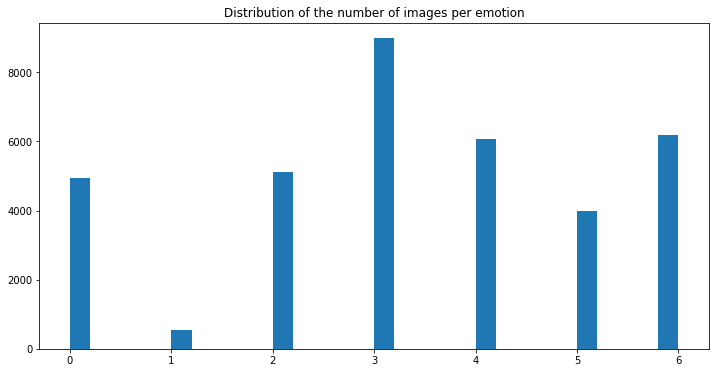

In [6]:
plt.figure(figsize=(12,6))
plt.hist(dataset['emotion'], bins=30)
plt.title("Distribution of the number of images per emotion")
plt.show()

In [7]:
train.shape

(28709, 3)

In [8]:
test.shape

(3589, 3)

# IV. Extract image features

We will now extract the following features :
- HOG sliding windows
- HOG features
- Facial landmarks

In [4]:
pictures = dataset['pixels']
labels = dataset['emotion']

In [5]:
shape_x = 48
shape_y = 48
window_size = 24
window_step = 6

ONE_HOT_ENCODING = False
SAVE_IMAGES = False
GET_LANDMARKS = False
GET_HOG_FEATURES = False
GET_HOG_WINDOWS_FEATURES = False
SELECTED_LABELS = []
IMAGES_PER_LABEL = 500

OUTPUT_FOLDER_NAME = "/Users/maelfabien/Desktop/LocalDB/Videos/Face_Features/"

In [6]:
predictor = dlib.shape_predictor('/Users/maelfabien/Desktop/LocalDB/Videos/landmarks/shape_predictor_68_face_landmarks.dat')

In [10]:
def get_landmarks(image, rects):
    if len(rects) > 1:
        raise BaseException("TooManyFaces")
    if len(rects) == 0:
        raise BaseException("NoFaces")
    return np.matrix([[p.x, p.y] for p in predictor(image, rects[0]).parts()])

In [13]:
def sliding_hog_windows(image):
    hog_windows = []
    for y in range(0, shape_x, window_step):
        for x in range(0, shape_y, window_step):
            window = image[y:y+window_size, x:x+window_size]
            hog_windows.extend(hog(window, orientations=8, pixels_per_cell=(8, 8),
                                            cells_per_block=(1, 1), visualise=False))
    return hog_windows

In [14]:
images = []
labels_list = []
landmarks = []

hog_slide_features = []
hog_slide_images = []

hog_features = []
hog_images = []

for i in range(len(pictures)):
    try:
        # Build the image as an array
        image = pictures[i].reshape((shape_x, shape_y))
        images.append(pictures[i])
        
        # HOG sliding windows features
        features = sliding_hog_windows(image)
        f, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16),cells_per_block=(1, 1), visualise=True)
        hog_slide_features.append(features)
        hog_slide_images.append(hog_image)
        
        # HOG features
        features, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16),
                                            cells_per_block=(1, 1), visualise=True)
        hog_features.append(features)
        hog_images.append(hog_image)

        # Facial landmarks
        scipy.misc.imsave('temp.jpg', image)
        image2 = cv2.imread('temp.jpg')
        face_rects = [dlib.rectangle(left=1, top=1, right=47, bottom=47)]
        face_landmarks = get_landmarks(image2, face_rects)
        landmarks.append(face_landmarks)            
        
        # Labels
        labels_list.append(labels[i])
        #nb_images_per_label[labels[i]] += 1
        
    except Exception as e:
        print( "error in image: " + str(i) + " - " + str(e))

/anaconda3/lib/python3.6/site-packages/skimage/feature/_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)
/anaconda3/lib/python3.6/site-packages/skimage/feature/_hog.py:248: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


Save the arrays :

In [15]:
np.save(OUTPUT_FOLDER_NAME + 'labels.npy', labels_list)

np.save(OUTPUT_FOLDER_NAME + 'hog_slide_image.npy', hog_slide_images)
np.save(OUTPUT_FOLDER_NAME + 'hog_slide_features.npy', hog_slide_features)

np.save(OUTPUT_FOLDER_NAME + 'hog_image.npy', hog_images)
np.save(OUTPUT_FOLDER_NAME + 'hog_features.npy', hog_features)

np.save(OUTPUT_FOLDER_NAME + 'landmarks.npy', landmarks)
np.save(OUTPUT_FOLDER_NAME + 'images.npy', images)

Re-open them :

In [5]:
labels_list = np.load(OUTPUT_FOLDER_NAME + 'labels.npy')

hog_slide_images = np.load(OUTPUT_FOLDER_NAME + 'hog_slide_image.npy')
hog_slide_features = np.load(OUTPUT_FOLDER_NAME + 'hog_slide_features.npy')

hog_images = np.load(OUTPUT_FOLDER_NAME + 'hog_image.npy')
hog_features = np.load(OUTPUT_FOLDER_NAME + 'hog_features.npy')

landmarks = np.load(OUTPUT_FOLDER_NAME + 'landmarks.npy')
images = np.load(OUTPUT_FOLDER_NAME + 'images.npy')

# V. Visualize HOG Features

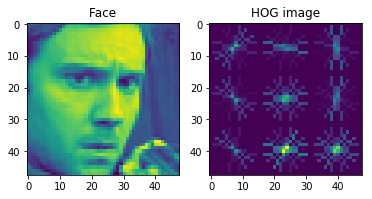

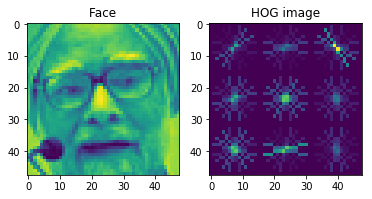

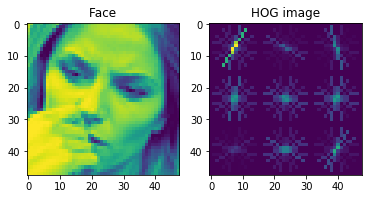

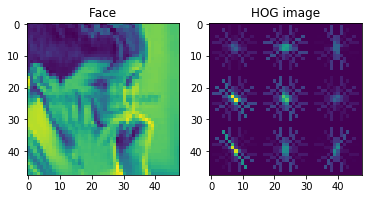

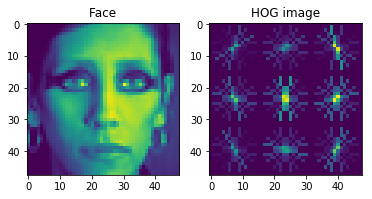

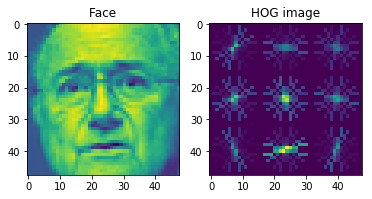

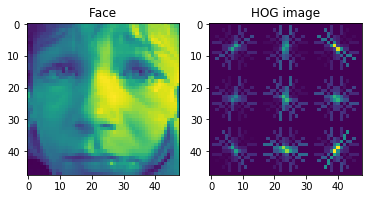

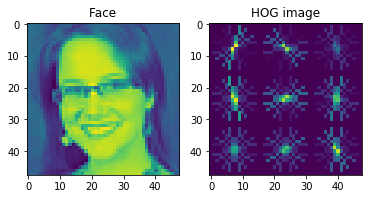

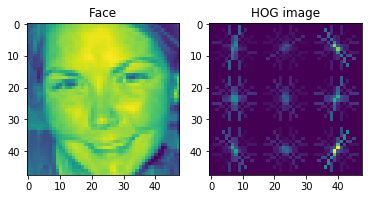

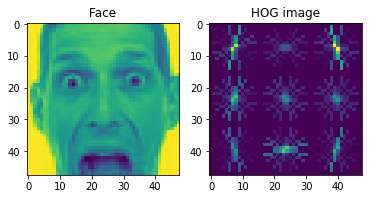

In [76]:
for i in range(10):
    fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True)
    ax = axs[0]
    ax.imshow(images[i].reshape((shape_x, shape_y)))
    ax.set_title('Face')

    ax = axs[1]
    ax.imshow(hog_images[i])
    ax.set_title('HOG image')

# VI. Build the model

## Build the train and test sets

Merge the different data sets :

In [6]:
landmarks = np.array([x.flatten() for x in landmarks])
landmarks.shape

(28709, 136)

In [7]:
data_0 = hog_features
data_1 = landmarks
data_2 = np.concatenate((landmarks, hog_features), axis=1)
data_3 = np.concatenate((landmarks, hog_slide_features), axis=1)

In [8]:
data_0.shape, data_1.shape, data_2.shape, data_3.shape

((28709, 72), (28709, 136), (28709, 208), (28709, 2728))

## Hog Features only

In [9]:
X_train, X_test, y_train, y_test = train_test_split(data_0, labels_list, test_size=0.25, random_state=42)

In [15]:
model = OneVsRestClassifier(SVC(random_state=42, max_iter=10000, kernel='rbf',gamma='auto'))

# Train
start_time = time()
model.fit(X_train, y_train)
training_time = time() - start_time
print("Training time : ", training_time)

# Predict
y_pred = model.predict(X_test)
accuracy_hog = accuracy_score(y_pred, y_test)
print("Accuracy : ", accuracy_hog)

Training time :  122.60713601112366
Accuracy :  0.32836444692114797


## Landmarks features only

In [16]:
X_train, X_test, y_train, y_test = train_test_split(data_1, labels_list, test_size=0.25, random_state=42)

In [17]:
model = OneVsRestClassifier(SVC(random_state=42, max_iter=10000, kernel='rbf',gamma='auto'))

# Train
start_time = time()
model.fit(X_train, y_train)
training_time = time() - start_time
print("Training time : ", training_time)

# Predict
y_pred = model.predict(X_test)
accuracy_hog = accuracy_score(y_pred, y_test)
print("Accuracy : ", accuracy_hog)

/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/b

Training time :  2793.0992209911346
Accuracy :  0.4639175257731959


## HOG & landmarks features

In [18]:
X_train, X_test, y_train, y_test = train_test_split(data_2, labels_list, test_size=0.25, random_state=42)

In [19]:
model = OneVsRestClassifier(SVC(random_state=42, max_iter=10000, kernel='rbf',gamma='auto'))

# Train
start_time = time()
model.fit(X_train, y_train)
training_time = time() - start_time
print("Training time : ", training_time)

# Predict
y_pred = model.predict(X_test)
accuracy_hog = accuracy_score(y_pred, y_test)
print("Accuracy : ", accuracy_hog)

/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/b

Training time :  801.6945312023163
Accuracy :  0.4752020061298412


## Sliding window HOG & landmarks features

In [20]:
X_train, X_test, y_train, y_test = train_test_split(data_3, labels_list, test_size=0.25, random_state=42)

In [21]:
model = OneVsRestClassifier(SVC(random_state=42, max_iter=100, kernel='rbf',gamma='auto'))

# Train
start_time = time()
model.fit(X_train, y_train)
training_time = time() - start_time
print("Training time : ", training_time)

# Predict
y_pred = model.predict(X_test)
accuracy_hog = accuracy_score(y_pred, y_test)
print("Accuracy : ", accuracy_hog)

/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:2

Training time :  135.3525631427765
Accuracy :  0.24686542212315407


# VII. Sources

- Visualization : https://github.com/JostineHo/mememoji/blob/master/data_visualization.ipynb
- State of the art Architecture : https://github.com/amineHorseman/facial-expression-recognition-using-cnn
- Eyes Tracking : https://www.pyimagesearch.com/2017/04/24/eye-blink-detection-opencv-python-dlib/
- Face Alignment : https://www.pyimagesearch.com/2017/05/22/face-alignment-with-opencv-and-python/
- C.Pramerdorfer,  and  M.Kampel.Facial  Expression  Recognition  using  Con-volutional  Neural  Networks:  State  of  the  Art.  Computer  Vision  Lab,  TU  Wien. https://arxiv.org/pdf/1612.02903.pdf
- A Brief Review of Facial Emotion Recognition Based
on Visual Information : https://www.mdpi.com/1424-8220/18/2/401/pdf
- Going deeper in facial expression recognition using deep neural networks : https://ieeexplore.ieee.org/document/7477450
- Emotional Deep Alignment Network paper : https://arxiv.org/abs/1810.10529
- Emotional Deep Alignment Network github : https://github.com/IvonaTau/emotionaldan
- HOG, Landmarks and SVM : https://github.com/amineHorseman/facial-expression-recognition-svm